# Setup

In [1]:
#Colab
# from google.colab import drive
# drive.mount('/content/drive')
# GNN_PATH = '/content/drive/MyDrive/Colab Notebooks/GNN/'

#HPC
GNN_PATH = './GNN/'
import os
if not os.path.exists(GNN_PATH):
    os.makedirs(GNN_PATH)

In [ ]:
# Install packages
!pip install torch-geometric torch scikit-learn pandas shapely seaborn
!pip install git+https://github.com/Thinklab-SJTU/pygmtools.git #pygmtools library

# Check pytorch version and make sure you use a GPU Kernel
import torch
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0))
!nvcc --version
# Check GPU
!nvidia-smi

#set device as cuda if available to load model and data on gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  Cloning https://github.com/Thinklab-SJTU/pygmtools.git to /private/var/folders/zp/9w1jzgvj7bq6mh7s68n3f7dh0000gn/T/pip-req-build-i1o_wnij
  Running command git clone --filter=blob:none --quiet https://github.com/Thinklab-SJTU/pygmtools.git /private/var/folders/zp/9w1jzgvj7bq6mh7s68n3f7dh0000gn/T/pip-req-build-i1o_wnij
  Resolved https://github.com/Thinklab-SJTU/pygmtools.git to commit 80399b1b07722340dd8d6e1bcce2618395fac2db
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
PyTorch version: 2.2.2
CUDA version: None
zsh:1: command not found: nvcc
zsh:1: command not found: nvidia-smi


In [ ]:
# Standard library
import copy
import pickle
import random
from pathlib import Path
from typing import List, Tuple

# Third-party libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import torch
from shapely.affinity import translate
from shapely.geometry import Polygon
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from tqdm import tqdm
# Local application/library-specific imports



In [4]:
# Set Seed for reproducibility
seed = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(seed)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(seed)

# Utilities

In [5]:
#----------------------------------------
#            DATASET UTILS
#----------------------------------------

def deserialize_MSD_dataset(data_path, original_path=None, noise_path=None, dimensions_path=None):
    dataset_dir = Path(data_path)

    dimensions = []
    if dimensions_path is not None:
        # Load dimensions
        dimensions_file = dataset_dir / f"{dimensions_path}.pickle"
        if not dimensions_file.exists():
            raise FileNotFoundError(f"Dimensions file not found at {dimensions_file}")
        with open(dimensions_file, 'rb') as f:
            dimensions = pickle.load(f)

    # Clear existing graphs
    original = []
    noise = []

    if original_path is not None:
        original_dir = dataset_dir / original_path
        original_files = sorted(original_dir.glob("*.pt"), key=lambda f: int(f.stem))

        for file in original_files:
            graph = nx.DiGraph()
            with open(str(file), "rb") as f:
                graph = pickle.load(f)
                graph.graph['name'] = file.stem
            original.append(graph)

    if noise_path is not None:
        def extract_numeric_key(file):
            """Extracts (X, Y) from filenames like 'X_Y.pt' for proper numeric sorting."""
            name_parts = file.stem.split("_")
            return int(name_parts[0]), int(name_parts[1])

        noise_dir = dataset_dir / noise_path
        noise_files = sorted(noise_dir.glob("*.pt"), key=extract_numeric_key)

        for file in noise_files:
            graph = nx.DiGraph()
            with open(str(file), "rb") as f:
                graph = pickle.load(f)
                graph.graph['name'] = file.stem
            noise.append(graph)

    return original, noise, dimensions

# TODO : definisci serialaze e deserialize per il nuovo dataset

def plot_a_graph(graphs_list, viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=False, viz_walls=True):
    """
    Visualizes geometries, wall segments, and graph edges for multiple apartments in 2D.

    Parameters:
    graphs_list (list of networkx.Graph): List of graphs with nodes ('type', 'center', 'normal') and edges for the apartments.
    viz_normals (bool): If True, plots wall segment normals.
    viz_rooms (bool): If True, displays room polygons.
    viz_ws (bool): If True, displays wall segments.
    viz_openings (bool): If True, displays openings (doors and windows).
    viz_wall_edges (bool): If True, displays edges between wall segments.
    viz_connection_edges (bool): If True, displays edges connecting rooms via openings.
    viz_walls (bool): If True, displays wall nodes and their edges.
    """
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    legend_added = False  # Flag to ensure the legend is added only once
    normal_added = False  # Flag to ensure the "Normal" label is added only once

    for graphs in graphs_list:
        # Visualize room polygons
        if viz_rooms:
            room_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'room']
            for idx, room_node in enumerate(room_nodes):
                room_data = graphs.nodes[room_node]
                # Plot the polygon
                room_polygon = Polygon(room_data['polygon'])
                x, y = room_polygon.exterior.xy
                ax.plot(x, y, color='black', alpha=0.2, label='Room polygon' if not legend_added and idx == 0 else "")
                # Draw room centroids
                ax.scatter(room_data['center'][0], room_data['center'][1], color='blue', s=100, label='Room centroid' if not legend_added and idx == 0 else "")

        # Visualize wall nodes and edges
        if viz_walls:
            wall_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'wall']
            for idx, wn in enumerate(wall_nodes):
                wall_data = graphs.nodes[wn]
                # Plot the polygon of the wall
                wall_polygon = Polygon(wall_data['polygon'])
                x, y = wall_polygon.exterior.xy
                ax.plot(x, y, color='purple', linestyle='-', label='Wall polygon' if not legend_added and idx == 0 else "")
                ax.scatter(wall_data['center'][0], wall_data['center'][1], color='purple', s=50, label='Wall centroid' if not legend_added and idx == 0 else "")
            
            if viz_normals:
                wall_ws = [n for n, d in graphs.nodes(data=True) if d['type'] == 'wall_ws']
                for idx, wn in enumerate(wall_ws):
                    ws_data = graphs.nodes[wn]
                    ax.scatter(ws_data['center'][0], ws_data['center'][1], color='purple', s=20, label='Wall ws' if not legend_added and idx == 0 else "")
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            wall_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'wall' in u or 'wall' in v]
            for idx, edge in enumerate(wall_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='purple', linestyle='--', label='Wall edge' if not legend_added and idx == 0 else "")

        # Visualize openings
        if viz_openings:
            opening_nodes = [n for n, d in graphs.nodes(data=True) if 'door' in d['type'] or 'window' in d['type']]
            for idx, on in enumerate(opening_nodes):
                opening_data = graphs.nodes[on]
                opening_polygon = Polygon(opening_data['polygon'])
                x, y = opening_polygon.exterior.xy
                ax.plot(x, y, color='orange', label='Opening polygon' if not legend_added and idx == 0 else "")
                # Draw opening centroids
                ax.scatter(opening_data['center'][0], opening_data['center'][1], color='orange', s=10, label='Opening centroid' if not legend_added and idx == 0 else "")

            if viz_normals:
                opening_ws = [n for n, d in graphs.nodes(data=True) if d['type'] == 'door_ws' or d['type'] == 'window_ws']
                for idx, wn in enumerate(opening_ws):
                    ws_data = graphs.nodes[wn]
                    ax.scatter(ws_data['center'][0], ws_data['center'][1], color='orange', s=10, label='Opening ws' if not legend_added and idx == 0 else "")
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            # Draw opening edges
            open_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'door' in u or 'window' in v or 'door' in v or 'window' in u]
            for idx, edge in enumerate(open_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='orange', linestyle='--', label='Opening edge' if not legend_added and idx == 0 else "")

        # Visualize ws room
        if viz_ws:
            ws_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'ws']
            for idx, wn in enumerate(ws_nodes):
                ws_data = graphs.nodes[wn]
                ax.scatter(ws_data['center'][0], ws_data['center'][1], color='red', s=20, label='Ws segment' if not legend_added and idx == 0 else "")
                if viz_room_normals:
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True
                if 'limits' in ws_data:
                    limit_1, limit_2 = ws_data['limits']
                    ax.plot([limit_1[0], limit_2[0]],
                            [limit_1[1], limit_2[1]],
                            color='black', linewidth=1.0,
                            label='Ws limits' if idx == 0 else "")
            ws_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'ws_same_room' in d['type'] or 'ws_belongs_room' in d['type']]
            for idx, edge in enumerate(ws_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                    [start_node['center'][1], end_node['center'][1]],
                    color='gray', linestyle='--', label='Ws edge' if not legend_added and idx == 0 else "")
                
        # Visualize connection edges
        if viz_room_connection:
            connection_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'connected' in d['type']]
            for idx, edge in enumerate(connection_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='blue', linestyle='-', label='Connection edge' if not legend_added and idx == 0 else "")

        legend_added = True  # Set the flag to True after processing the first graph

    plt.title("Apartment Graph Visualization")
    plt.legend()
    plt.show()

node_type_mapping = {"room": [1, 0], "ws": [0, 1]}
# Functions to convert DiGraphs to pyg data and viceversa, pyg data are more compatible with GNN models
def pyg_data_to_nx_digraph(data: Data, graph_list: List[nx.DiGraph]) -> nx.DiGraph:
    """
    Convert a PyTorch Geometric Data object back to a NetworkX DiGraph,
    restoring original node IDs using data.node_names and matching it
    with the graph in graph_list that has the same name.
    """
    assert hasattr(data, 'node_names'), "Data object must contain 'node_names' to restore original node IDs."
    assert hasattr(data, 'name'), "Data object must contain 'name' to match with graph_list."

    # Find the matching graph in the list by name
    matching_graph = next((g for g in graph_list if g.graph.get('name') == data.name), None)
    if matching_graph is None:
        raise ValueError(f"No graph with name {data.name} found in the provided graph_list.")

    G = nx.DiGraph()

    node_ids = data.node_names

    # Add nodes with attributes from the matching graph
    for i, node_id in enumerate(node_ids):
        if node_id in matching_graph.nodes:
            G.add_node(node_id, **matching_graph.nodes[node_id])

    # Add edges mapped back to original IDs
    edge_index = data.edge_index
    for u_idx, v_idx in edge_index.t().tolist():
        u = node_ids[u_idx]
        v = node_ids[v_idx]
        if matching_graph.has_edge(u, v):
            G.add_edge(u, v, **matching_graph.edges[u, v])

    # Add the graph name
    G.graph['name'] = data.name
    G.graph['node_names'] = data.node_names

    return G
    
def nx_to_pyg_data_preserve_order(graph: nx.DiGraph) -> Data:
    """
    Convert a NetworkX DiGraph to a PyTorch Geometric Data object,
    preserving the insertion order of nodes.
    """
    node_ids = list(graph.nodes())  # preserve insertion order
    id_map = {node_id: i for i, node_id in enumerate(node_ids)}

    # Build node features tensor
    x = torch.stack([
        torch.tensor(
            node_type_mapping[graph.nodes[n]['type']] +  # One-hot encoding for 'type'
            graph.nodes[n]['center'] +  # 'center' coordinates
            graph.nodes[n]['normal'] +  # 'normal' vector
            [graph.nodes[n].get('width', -1)],  # 'width', default to -1 if not present
            dtype=torch.float32
        )
        for n in node_ids
    ])

    # Remap edges using the insertion-order mapping
    edge_index = torch.tensor([
        [id_map[u], id_map[v]] for u, v in graph.edges()
    ], dtype=torch.long).t().contiguous() if graph.edges else torch.empty((2, 0), dtype=torch.long)

    # Optionally, store the original node order as a list of IDs
    data = Data(x=x, edge_index=edge_index)
    data.node_names = node_ids  # so you can always recover original labels
    data.name = graph.graph.get("name")

    return data

def generate_matching_pair_as_data(
    g1: nx.DiGraph,
    g2: nx.DiGraph,
    pairs_list: List[Tuple[Data, Data, torch.Tensor]]
) -> None:
    """
    Generate a matching pair as torch_geometric Data objects with a permutation matrix.

    Args:
        g1: Reference graph as networkx.DiGraph
        g2: Target graph as networkx.DiGraph (to be permuted)
        pairs_list: List to store (Data1, Data2_permuted, P) tuples
    """
    # TODO : cambia centro, norma a 2D e controlla lenght per g1 e g2
    pyg_g1 = nx_to_pyg_data_preserve_order(g1)

    assert g2.number_of_nodes() == pyg_g1.num_nodes, "Mismatch in number of nodes between g1 and g2"

    num_nodes = g2.number_of_nodes()
    nodes_g2 = list(sorted(g2.nodes()))
    assert nodes_g2 == list(range(num_nodes)), "Nodes in g2 must be consecutively indexed"

    # Create a random permutation
    perm = torch.randperm(num_nodes)

    # Build the permutation matrix: P[i, j] = 1 if node i in G1 matches node j in G2_permuted
    P = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
    for i in range(num_nodes):
        P[i, perm[i]] = 1.0

    # Create permuted G2
    g2_permuted = nx.DiGraph()
    g2_permuted.graph['name'] = g2.graph.get('name', '')

    for new_idx in range(num_nodes):
        old_idx = perm[new_idx].item()
        g2_permuted.add_node(
            new_idx,
            type=g2.nodes[old_idx]['type'],
            center=g2.nodes[old_idx]['center'],
            normal=g2.nodes[old_idx]['normal'],
            width=g2.nodes[old_idx].get('length', -1)
        )

    for u, v, data in g2.edges(data=True):
        new_u = (perm == u).nonzero(as_tuple=True)[0].item()
        new_v = (perm == v).nonzero(as_tuple=True)[0].item()
        g2_permuted.add_edge(new_u, new_v, **data)

    pyg_g2 = nx_to_pyg_data_preserve_order(g2_permuted)
    pairs_list.append((pyg_g1, pyg_g2, P.T))  # P.T: P[i, j] = G1[i] ↔ G2[j]

def normalize_data_pairs(
    pairs: List[Tuple[Data, Data, torch.Tensor]],
    mean: torch.Tensor,
    std: torch.Tensor
) -> List[Tuple[Data, Data, torch.Tensor]]:
    """
    Normalizza per-feature i tensori x in ciascun Data object all'interno delle tuple.

    Args:
        pairs: Lista di tuple (Data1, Data2, P)
        mean: Tensor di media per-feature (shape: [num_features])
        std: Tensor di deviazione standard per-feature (shape: [num_features])

    Returns:
        Lista di tuple con i Data normalizzati.
    """
    normalized_pairs = []
    for data1, data2, P in pairs:
        data1.x = (data1.x - mean) / (std + 1e-8)
        data2.x = (data2.x - mean) / (std + 1e-8)
        normalized_pairs.append((data1, data2, P))
    return normalized_pairs

def compute_mean_std(pairs: List[Tuple[Data, Data, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Calcola la media e la deviazione standard per-feature dai Data objects nel training set.

    Args:
        pairs: Lista di tuple (Data1, Data2, P) del training set

    Returns:
        Tuple contenente (mean, std) per-feature
    """
    x_list = []
    for data1, data2, _ in pairs:
        x_list.append(data1.x)
        x_list.append(data2.x)
    x_all = torch.cat(x_list, dim=0)
    mean = x_all.mean(dim=0)
    std = x_all.std(dim=0)
    return mean, std


#----------------------------------------
#            TRAINING UTILS
#----------------------------------------

# Create the plot
def plot_losses(train_losses, val_losses):
    epochs = list(range(len(train_losses)))
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=epochs, y=train_losses, label="Training Loss")
    sns.lineplot(x=epochs, y=val_losses, label="Validation Loss")

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

def apply_inverse_permutation_to_graph(g2: nx.DiGraph, inv_perm: torch.Tensor) -> nx.DiGraph:
    """
    Riordina i nodi del grafo g2 secondo la permutazione inversa.
    """
    reordered = nx.DiGraph()
    mapping = {}

    for i, original_idx in enumerate(inv_perm.tolist()):
        node_data = g2.nodes[original_idx]
        reordered.add_node(i, **node_data)
        mapping[original_idx] = i

    # TODO: edge copy is wrong, but it doesn't matter for the moment
    for u, v, data in g2.edges(data=True):
        if u in mapping and v in mapping:
            reordered.add_edge(mapping[u], mapping[v], **data)

    reordered.graph.update(g2.graph)  # copy graph-level attributes
    return reordered

def plot_two_graphs_with_matching(graphs_list, gt_perm, pred_perm, original_graphs,
                                  viz_rooms=True, viz_ws=True,
                                  viz_room_connection=True,
                                  viz_normals=False, viz_room_normals=False,
                                  match_display="all"): 
    """
    Visualizes two graphs side by side with matching edges.
    G1 is plotted as-is, G2 is translated to the right.

    Args:
        graphs_list (list): [G1, G2] as networkx.DiGraph
        gt_perm (Tensor): Ground truth permutation matrix
        pred_perm (Tensor): Predicted permutation matrix
        match_display (str): 'all', 'correct', or 'wrong'
    """
    assert match_display in {"all", "correct", "wrong"}, "match_display must be one of: 'all', 'correct', 'wrong'"
    assert len(graphs_list) == 2, "graphs_list must contain exactly two graphs."
    
    g1tensor, g2tensor = copy.deepcopy(graphs_list[0]), copy.deepcopy(graphs_list[1])  # avoid modifying original

    #Convert tensor to digraph for rappresentation
    g1 = copy.deepcopy(pyg_data_to_nx_digraph(g1tensor, original_graphs))
    g2_original = copy.deepcopy(pyg_data_to_nx_digraph(g2tensor, original_graphs))

    # Apply inverse permutation to g2 to get the correct matching
    inv_perm = gt_perm.T.argmax(dim=1)
    g2 = apply_inverse_permutation_to_graph(g2_original, inv_perm)

    # # Check if the permuted graphs are equal
    # # convert g2_reordered in pyg
    # g2_reordered_pyg = nx_to_pyg_data_preserve_order(g2)
    # assert torch.equal(g2tensor.x, g2_reordered_pyg.x), "I tensori non sono uguali!"
    
    # Compute translation
    max_x_g1 = max(data['center'][0] for _, data in g1.nodes(data=True))
    min_x_g2 = min(data['center'][0] for _, data in g2.nodes(data=True))
    translation_x = (max_x_g1 - min_x_g2) + 10.0

    for _, data in g2.nodes(data=True):
        data['center'][0] += translation_x
        if 'polygon' in data:
            poly = data['polygon']
            if isinstance(poly, Polygon):
                data['polygon'] = translate(poly, xoff=translation_x)
            else:
                data['polygon'] = Polygon([(x + translation_x, y) for x, y in poly])

    fig, ax = plt.subplots(figsize=(16, 10))
    legend_added = set()

    def plot_graph(g, is_g1):
        color_room = 'blue' if is_g1 else 'orange'
        color_ws = 'red' if is_g1 else 'purple'
        prefix = "(G1)" if is_g1 else "(G2)"

        if viz_rooms:
            for n, d in g.nodes(data=True):
                if d['type'] == 'room':
                    if 'polygon' in d:
                        poly = d['polygon']
                        if not isinstance(poly, Polygon):
                            poly = Polygon(poly)
                        x, y = poly.exterior.xy
                        ax.plot(x, y,
                                color='black' if is_g1 else 'gray',
                                linewidth=1, alpha=0.6,
                                label=f"Room polygon {prefix}" if "room-poly-"+prefix not in legend_added else "")
                        legend_added.add("room-poly-"+prefix)

                    ax.scatter(d['center'][0], d['center'][1],
                               color=color_room, s=80,
                               label=f"Centroid {prefix}" if "room-pt-"+prefix not in legend_added else "")
                    legend_added.add("room-pt-"+prefix)

        if viz_ws:
            for n, d in g.nodes(data=True):
                if d['type'] == 'ws':
                    ax.scatter(d['center'][0], d['center'][1], color=color_ws, s=20,
                               label=f"WS {prefix}" if "ws-"+prefix not in legend_added else "")
                    legend_added.add("ws-"+prefix)

    # Plot nodes and polygons
    plot_graph(g1, is_g1=True)
    plot_graph(g2, is_g1=False)

    # Draw matchings based on predicted permutation
    for i in range(pred_perm.shape[0]):
        j = pred_perm[i].argmax().item()

        pt1 = g1.nodes[i]['center']
        pt2 = g2.nodes[j]['center']
        
        is_correct = gt_perm[i, j] == 1

        if match_display == "correct" and not is_correct:
            continue
        if match_display == "wrong" and is_correct:
            continue

        color = 'green' if is_correct else 'red'
        label = None
        if color == 'green' and 'correct' not in legend_added:
            label = 'Correct match'
            legend_added.add('correct')
        elif color == 'red' and 'wrong' not in legend_added:
            label = 'Wrong match'
            legend_added.add('wrong')

        ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]],
                color=color, linestyle='-', alpha=0.6, linewidth=1, label=label)

        ax.set_title("Graph Matching: Green = Correct, Red = Wrong")
        ax.axis("equal")
        ax.legend()
    plt.tight_layout()
    plt.show()


# MSD dataset for SLAM

## Graph Matching with GNN from scratch 

### Dataset visualization and Preprocessing 

In [6]:
original_graphs, noise_graphs, dimensions = deserialize_MSD_dataset("data")

# Check the number of graphs
print(f"Number of original graphs: {len(original_graphs)}")
print(f"Number of noise graphs: {len(noise_graphs)}")

Number of original graphs: 67
Number of noise graphs: 496


 Checks on dataset

In [7]:
assert len(original_graphs) == len(dimensions), "Number of original and dimensions must be the same dim"
tot_graphs = 0
for i in range(len(dimensions)):
    tot_graphs += dimensions[i]
assert len(noise_graphs) == tot_graphs, "Number of noise graphs must be equal to the sum of dimensions"

for i, graph in enumerate(original_graphs):
    assert i == int(graph.graph['name']), "Graph name must match the index"

blocks = []
start = 0
for size in dimensions:
    end = start + size
    blocks.append(noise_graphs[start:end])
    start = end

def assert_block_names(blocks):
    for i, block in enumerate(blocks):
        base_names = [g.graph['name'].split("_")[0] for g in block]
        all_same = all(name == base_names[0] for name in base_names)
        assert all_same, f"Blocco {i+1}: nomi base diversi {base_names}"

assert_block_names(blocks)

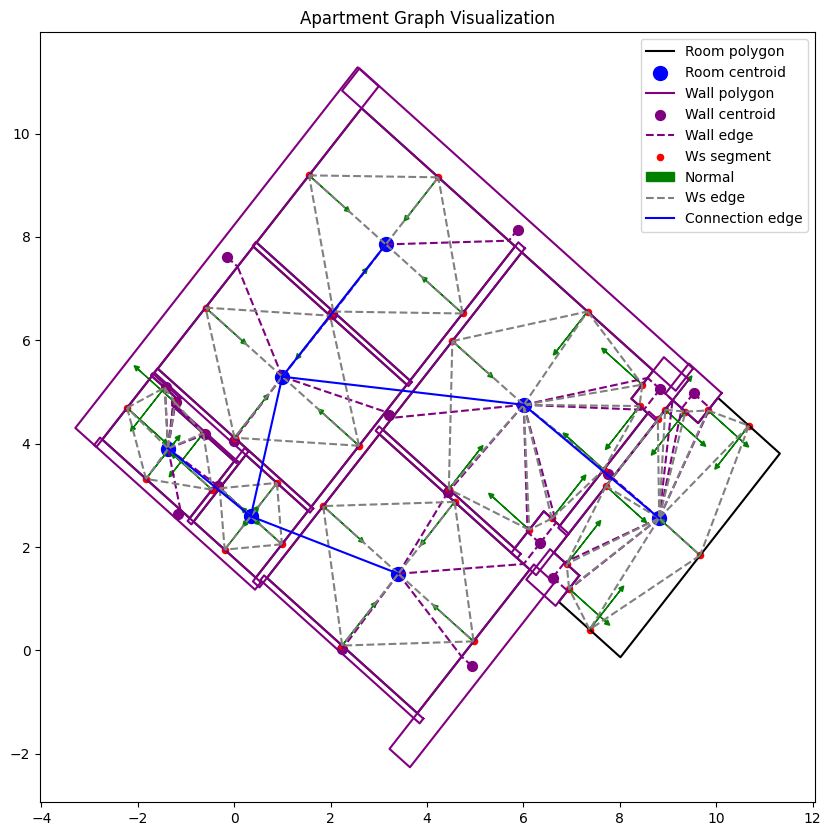

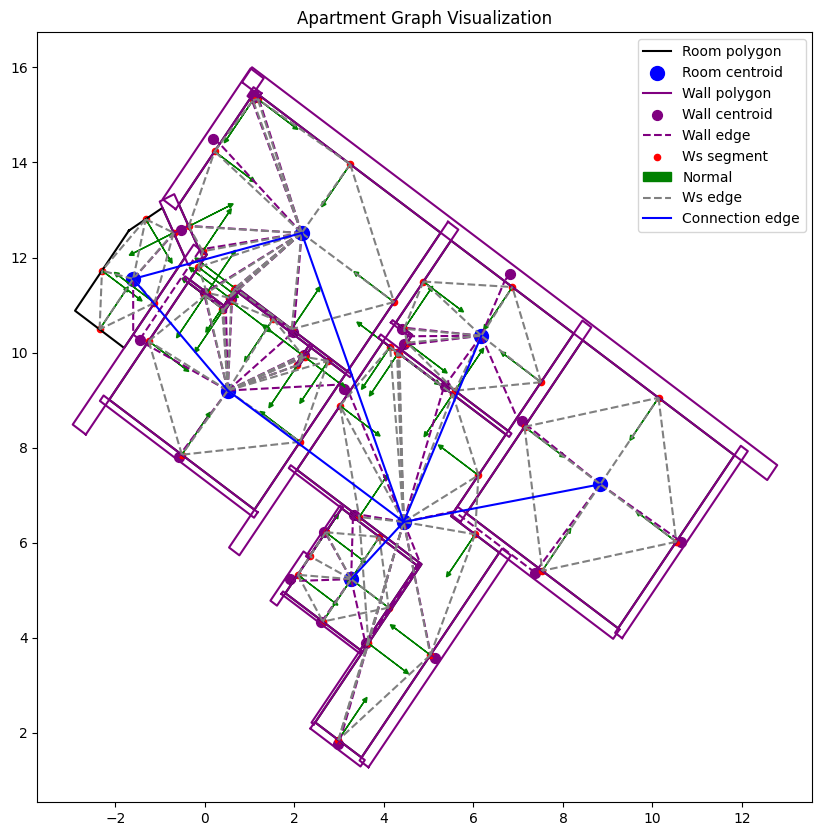

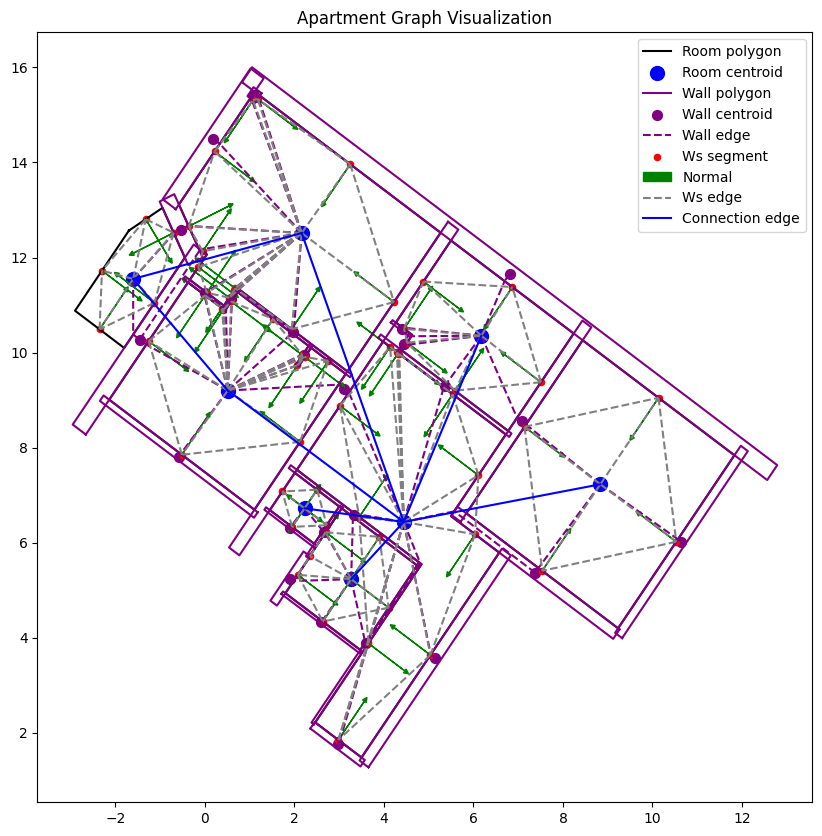

In [8]:
plot_a_graph([original_graphs[0]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

plot_a_graph([noise_graphs[60]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)
plot_a_graph([noise_graphs[61]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

53
176
270
77
144


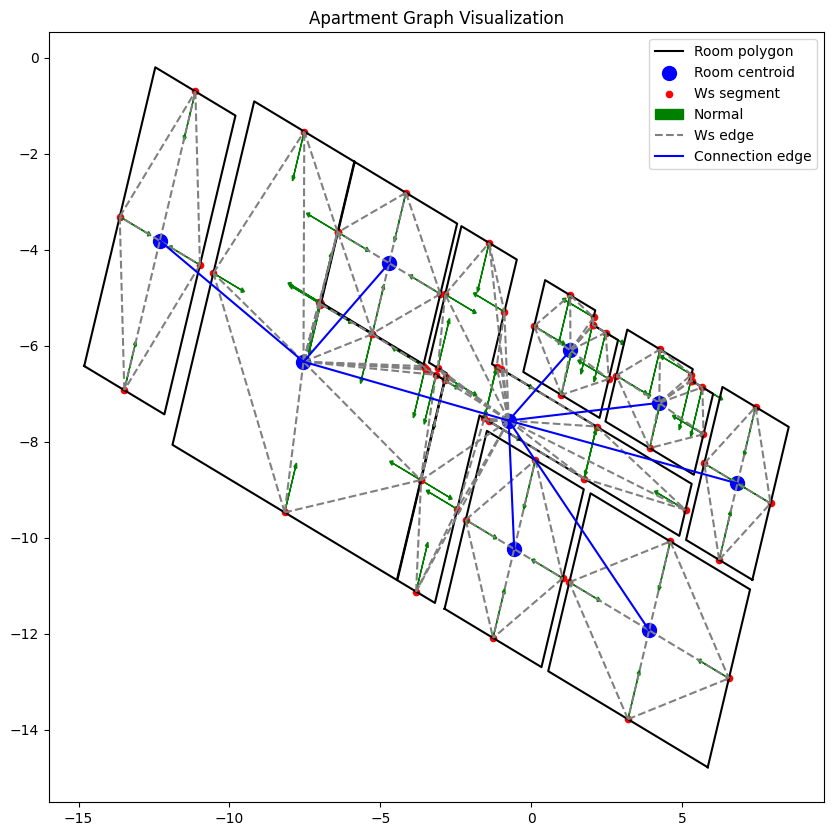

[(0, {'polygon': [(5.846049326444277, -14.779839661155272), (0.5601585648652261, -12.778463267850064), (1.9623488861879341, -9.075099477686202), (7.248239647766985, -11.076475870991409), (5.846049326444277, -14.779839661155272)], 'center': [3.9041991063161054, -11.927469569420737, 1.3], 'normal': [0, 0, 1], 'type': 'room', 'category': 0, 'category_letter': 'Bedroom'}), (1, {'geom': [array([  5.84604933, -14.77983966]), array([  0.56015856, -12.77846327])], 'polygon': [(5.846049326444277, -14.779839661155272), (0.5601585648652261, -12.778463267850064), (0.5601585648652261, -12.768463267850064), (5.846049326444277, -14.769839661155272), (5.846049326444277, -14.779839661155272)], 'center': [3.2031039456547514, -13.779151464502668, 1.3], 'normal': [0.3540947755505674, 0.9352095433258759, 0.0], 'width': 5.652092409986421, 'type': 'ws', 'category': 9}), (2, {'geom': [array([  0.56015856, -12.77846327]), array([ 1.96234889, -9.07509948])], 'polygon': [(0.5601585648652261, -12.778463267850064)

In [9]:
print(original_graphs[53].graph['name'])
print(len(original_graphs[53].nodes))
print(len(original_graphs[53].edges))
# remove all node which has type != "room" or "ws"
def remove_non_room_ws(graphs):
    for graph in graphs:
        nodes_to_remove = [n for n, d in graph.nodes(data=True) if d['type'] not in ['room', 'ws']]
        graph.remove_nodes_from(nodes_to_remove)
    return graphs
original_graphs = remove_non_room_ws(original_graphs)
noise_graphs = remove_non_room_ws(noise_graphs)

# convert id to int
for i, graph in enumerate(original_graphs):
    original_graphs[i] = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='default')
for i, graph in enumerate(noise_graphs):
    noise_graphs[i] = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='default')


print(len(original_graphs[53].nodes))
print(len(original_graphs[53].edges))
plot_a_graph([original_graphs[53]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=False)
print(original_graphs[53].nodes(data=True))
print(original_graphs[53].edges(data=True))

#### Generate G1,G2,GT dataset

Data(x=[77, 9], edge_index=[2, 144], node_names=[77], name='53')
G1 nodes: tensor([ 3.0725e+00, -3.0725e+00,  8.7680e-01, -1.9459e+00, -1.1921e+01,
         5.6390e-03, -2.2504e-02,  3.0725e+00, -1.3113e+00])
Data(x=[77, 9], edge_index=[2, 144], node_names=[77], name='53')
G2 permuted nodes: tensor([ -0.3254,   0.3254,   0.2224,  -1.3667, -11.9209,  -0.5202,  -1.4156,
         -0.3254,   1.1410])
Ground truth permutation:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])


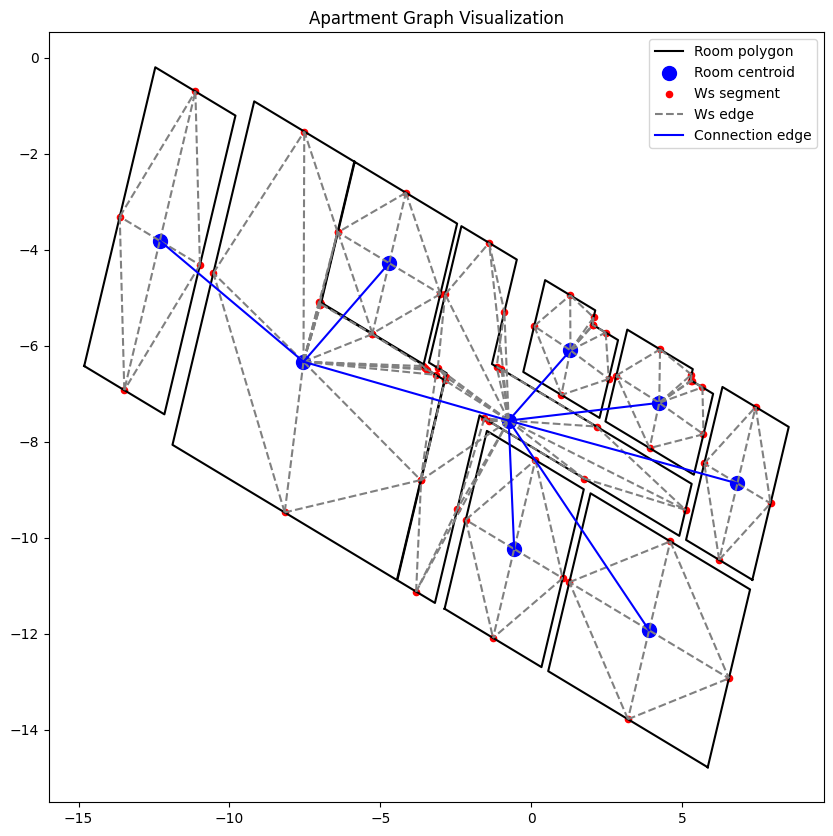

In [ ]:
# Split the data into 60% train, 20% validation, and 20% test
def split_graphs(graphs):
    train, temp = train_test_split(graphs, test_size=0.4, random_state=seed)
    val, test = train_test_split(temp, test_size=0.5, random_state=seed)
    return train, val, test

train, val, test = split_graphs(original_graphs)

train_list = []
for i, g1 in enumerate(train):
    generate_matching_pair_as_data(g1, g1, train_list)

val_list = []
for i, g1 in enumerate(val):
    generate_matching_pair_as_data(g1, g1, val_list)

test_list = []
for i, g1 in enumerate(test):
    generate_matching_pair_as_data(g1, g1, test_list)


# compute mean and std
mean, std = compute_mean_std(train_list)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train_list, mean, std)
val_pairs_norm = normalize_data_pairs(val_list, mean, std)
test_pairs_norm = normalize_data_pairs(test_list, mean, std)


# Visualize the two graphs
g1_out, g2_perm, gt_perm = train_list[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

g1_out = pyg_data_to_nx_digraph(g1_out, original_graphs)
g2_perm = pyg_data_to_nx_digraph(g2_perm, original_graphs)

plot_a_graph(
    graphs_list=[g1_out],
    viz_rooms=True,
    viz_ws=True,
    viz_openings=False,
    viz_room_connection=True,
    viz_normals=False,
    viz_room_normals=False,
    viz_walls=False
)

In [30]:
from torch.utils.data import Dataset

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):  # lista di (Data, Data, P)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]  # data1, data2, P
    
from torch_geometric.data import Batch

def collate_pyg_matching(batch):
    data1_list, data2_list, perm_list = zip(*batch)
    batch1 = Batch.from_data_list(data1_list)
    batch2 = Batch.from_data_list(data2_list)
    return batch1, batch2, perm_list

train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

### Model

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class MatchingModel_2GCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.gnn = nn.ModuleList([
            GCNConv(in_dim, hidden_dim),
            GCNConv(hidden_dim, out_dim)
        ])

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
        return x  # shape [num_nodes, out_dim]

    def forward(self, x1, edge_index1, x2, edge_index2):
        """
        Args:
            x1, x2: node features of graph 1 and 2 (shapes [N, in_dim])
            edge_index1, edge_index2: edge indices of graph 1 and 2 ([2, num_edges])

        Returns:
            scores: similarity matrix [N, N], where scores[i, j] = node i in G1 vs node j in G2
        """
        h1 = self.encode(x1, edge_index1)  # [N, D]
        h2 = self.encode(x2, edge_index2)  # [N, D]
        scores = torch.matmul(h1, h2.T)    # [N, N]
        return scores

### Training

In [ ]:
import torch.nn.functional as F

def train_epoch(model, loader, optimizer):
    """
    Train the model for one epoch and return the average loss and the embeddings.

    Returns:
        avg_loss, h1_all (list of h1), h2_all (list of h2)
    """
    model.train()
    total_loss = 0
    h1_all, h2_all = [], []

    for batch1, batch2, P in loader:
        optimizer.zero_grad()

        x1, edge1 = batch1.x.to(device), batch1.edge_index.to(device)
        x2, edge2 = batch2.x.to(device), batch2.edge_index.to(device)
        batch_idx1 = batch1.batch.to(device)
        batch_idx2 = batch2.batch.to(device)

        h1 = model.encode(x1, edge1)
        h2 = model.encode(x2, edge2)

        loss = 0.0
        B = len(P)

        for i in range(B):
            h1_i = h1[batch_idx1 == i]
            h2_i = h2[batch_idx2 == i]

            sim = torch.matmul(h1_i, h2_i.T)
            loss += F.binary_cross_entropy_with_logits(sim, P[i])

            h1_all.append(h1_i)
            h2_all.append(h2_i)

        loss /= B
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    return avg_loss, h1_all, h2_all


def evaluate(model, loader):
    """
    Evaluate the model on a validation/test set and return both accuracy and loss.

    Returns:
        accuracy, avg_loss
    """
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for batch1, batch2, P in loader:
            x1, edge1 = batch1.x.to(device), batch1.edge_index.to(device)
            x2, edge2 = batch2.x.to(device), batch2.edge_index.to(device)
            batch_idx1 = batch1.batch.to(device)
            batch_idx2 = batch2.batch.to(device)


            h1 = model.encode(x1, edge1)
            h2 = model.encode(x2, edge2)

            B = len(P)

            for i in range(B):
                h1_i = h1[batch_idx1 == i]
                h2_i = h2[batch_idx2 == i]

                sim = torch.matmul(h1_i, h2_i.T)

                pred = sim.argmax(dim=1)
                target = P[i].argmax(dim=1)

                correct += (pred == target).sum().item()
                total += h1_i.size(0)

                total_loss += F.binary_cross_entropy_with_logits(sim, P[i], reduction='sum').item()

    avg_loss = total_loss / total if total > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    return accuracy, avg_loss


In [33]:
from torch.utils.data import DataLoader

# Paths for saving models
best_val_model_path = os.path.join(GNN_PATH, 'best_val_model.pt')
final_model_path = os.path.join(GNN_PATH, 'final_model.pt')

# Define hyperparameters
in_dim = 9  # Dimension of node features
hidden_dim = 64  # Hidden dimension for GNN
out_dim = 32  # Output dimension for GNN
num_epochs = 100
learning_rate = 0.001
batch_size = 2

# Early stopping parameters
best_val_loss = float('inf')
patience = 20
patience_counter = 0
best_epoch = -1  # To track when best model was found


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

model = MatchingModel_2GCN(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, _, _ = train_epoch(model, train_loader, optimizer)
    # Evaluate on validation set
    _, val_loss = evaluate(model, val_loader)
    # Accumulate Losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check if validation improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_epoch = epoch
        # Save the best model seen so far
        torch.save(model.state_dict(), best_val_model_path)
    else:
        patience_counter += 1

    # Print progress every 100 epochs
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

# Save the final model
torch.save(model.state_dict(), final_model_path)
print("\nTraining completed.")

Starting training...
Epoch 0 | Train Loss: 89.9758 | Val Loss: 2324.8871
Epoch 99 | Train Loss: 0.6945 | Val Loss: 53.4896

Training completed.


### Training and Evalutation results

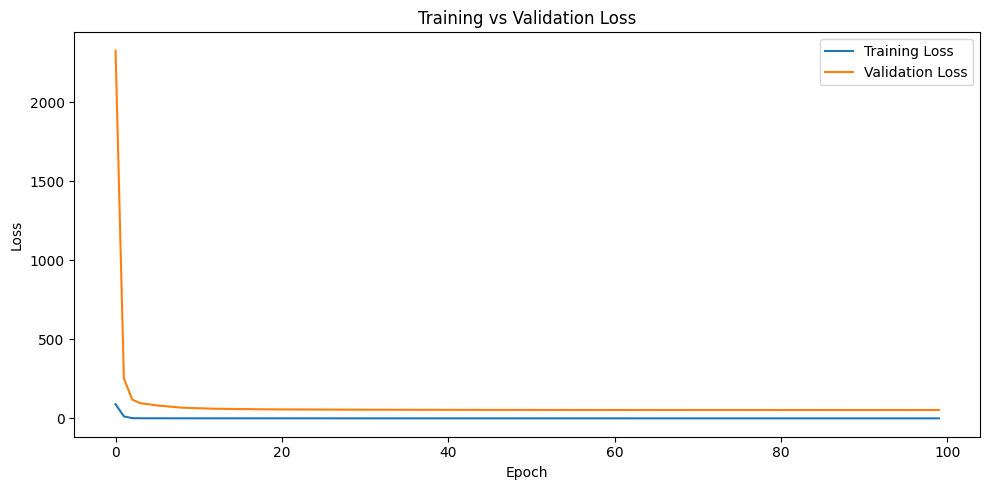

In [34]:
plot_losses(train_losses, val_losses)

In [ ]:
# Load the best model
model.load_state_dict(torch.load(best_val_model_path, map_location=device))
model.to(device)

# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Test Accuracy: 0.1983 | Test Loss: 57.2240


### Inference

In [ ]:
import time

def predict_matching_matrix(model, data1, data2, hard=True):
    model.eval()
    with torch.no_grad():
        data1 = data1.to(device)
        data2 = data2.to(device)
        h1 = model.encode(data1.x, data1.edge_index)
        h2 = model.encode(data2.x, data2.edge_index)
        sim = torch.matmul(h1, h2.T)  # [N1, N2]

        if hard:
            pred = sim.argmax(dim=1)
            P_pred = torch.zeros_like(sim)
            P_pred[torch.arange(sim.size(0)), pred] = 1
            return P_pred
        else:
            return F.softmax(sim, dim=1)

# use the model to predict the matching on a test graph
g1_out, g2_perm, gt_perm = test_list[0]
start_time = time.time()
P_pred = predict_matching_matrix(model, g1_out, g2_perm, hard=True)
end_time = time.time()

inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")
print(P_pred)  # matrice binaria di permutazione predetta


Inference time: 0.028334 seconds
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


### Visualization of results

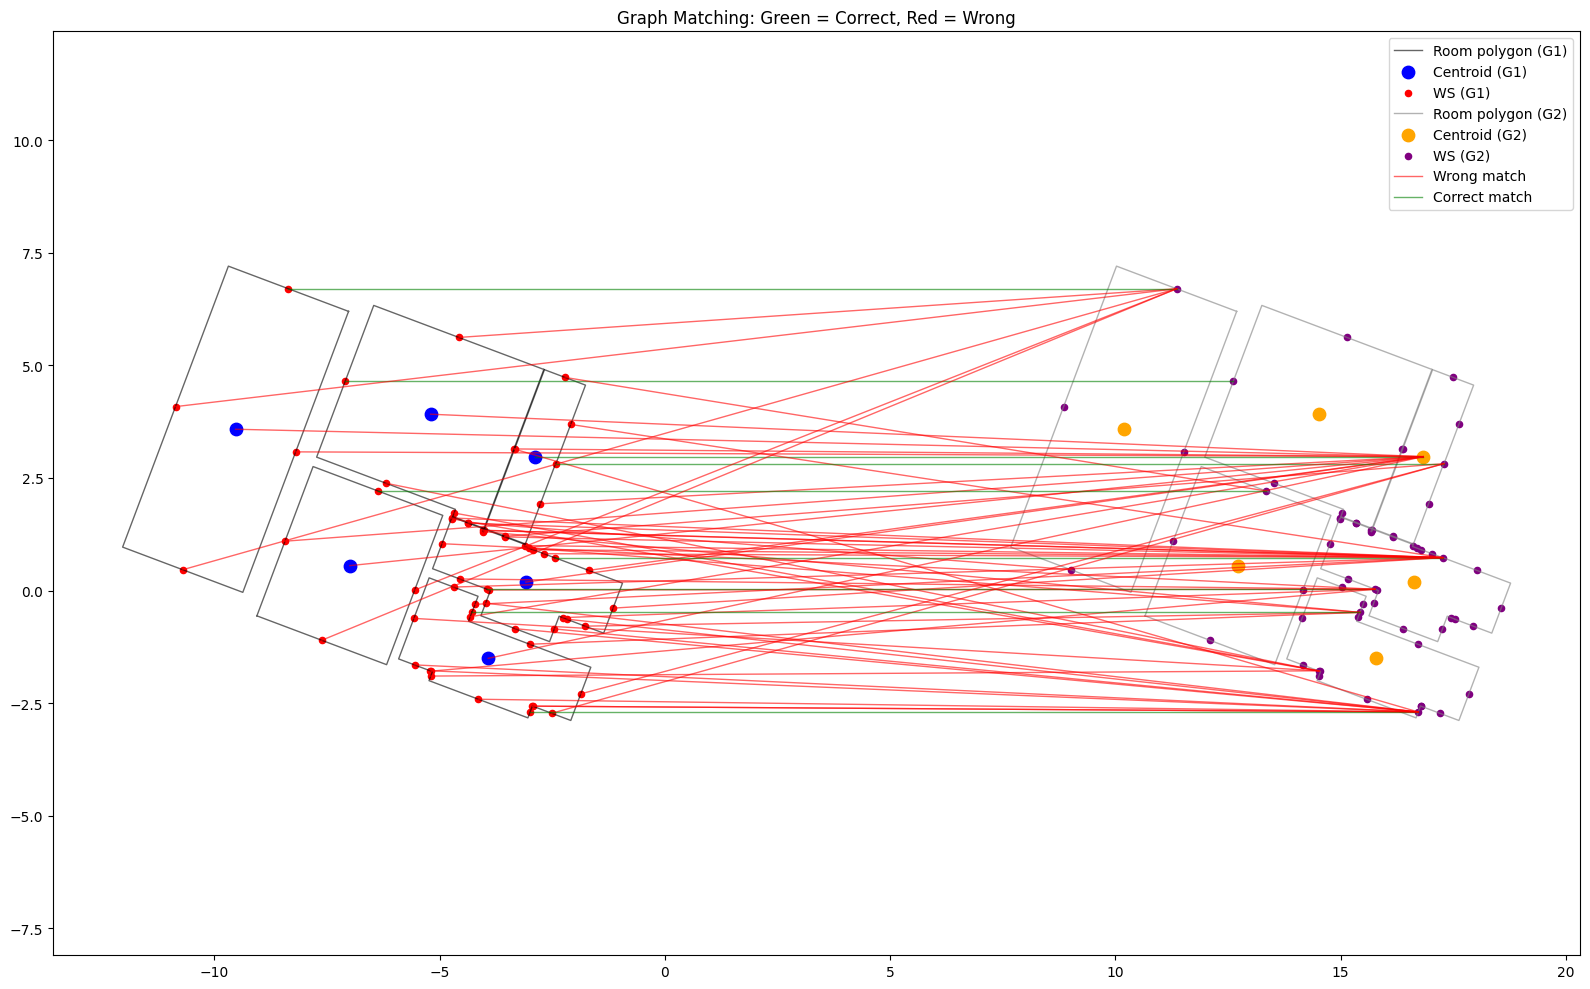

In [39]:
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=P_pred,
    original_graphs=original_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
)

# Graph matching

## Dataset Preprocessing


In [6]:
# Construct the folders if they don't exist 
# GNN_PATH
# ├── models
# │   ├── graph matching
# │   │   ├── equal
# │   │   ├── global
# │   │   ├── global + local
# │   │   └── local
# │   └── partial graph matching
# │       ├── room + ws dropout
# │       ├── room dropout
# │       └── ws dropout
# ├── preprocessed
# │   ├── graph matching
# │   │   ├── equal
# │   │   ├── global
# │   │   ├── global + local
# │   │   └── local
# │   └── partial graph matching
# │       ├── room + ws dropout
# │       ├── room dropout
# │       └── ws dropout
# └── raw
#     ├── graph matching
#     │   ├── equal
#     │   ├── global
#     │   ├── global + local
#     │   └── local
#     └── partial graph matching
#         ├── room + ws dropout
#         ├── room dropout
#         └── ws dropout

def create_dir_structure(base_dir="GNN"):
    categories = [
        "graph_matching/equal",
        "graph_matching/global",
        "graph_matching/global + local",
        "graph_matching/local",
        "partial_graph_matching/room + ws dropout",
        "partial_graph_matching/room dropout",
        "partial_graph_matching/ws dropout",
    ]

    levels = ["models", "preprocessed", "raw"]

    for level in levels:
        for category in categories:
            path = os.path.join(base_dir, level, category)
            os.makedirs(path, exist_ok=True)

if __name__ == "__main__":
    create_dir_structure(GNN_PATH)


### Dataset visualization and Preprocessing 

In [7]:
# graph matching-equal path 
gm_equal_path = os.path.join("GNN", "raw", "graph_matching")
original_graphs, noise_graphs, dimensions = deserialize_MSD_dataset(data_path=gm_equal_path, original_path="equal")

Number of original graphs: 4895
DiGraph named '0' with 72 nodes and 135 edges
[('1588_dd7f04c697c2d6ba20587aad0f95b928_Bathroom_0_centroid', {'polygon': [(-2.686670491863686, 0.4668536761608362), (-3.6110840113438654, -0.6348194567223242), (-4.897068796483341, 0.4442499021878046), (-4.995663966332997, 0.3267487543070384), (-5.5228870429102015, 0.7691414434111206), (-4.499878353580366, 1.988315724175047), (-2.686670491863686, 0.4668536761608362)], 'center': [-4.090207998488549, 0.6746409827536922], 'normal': [0, 0], 'type': 'room', 'category': 7, 'category_letter': 'Bathroom', 'viz_data': [-4.090207998488549, 0.6746409827536922]}), ('1588_dd7f04c697c2d6ba20587aad0f95b928_Bathroom_0_ws_0', {'geom': [array([-2.68667049,  0.46685368]), array([-3.61108401, -0.63481946])], 'polygon': [(-2.686670491863686, 0.4668536761608362), (-3.6110840113438654, -0.6348194567223242), (-3.6110840113438654, -0.6248194567223242), (-2.686670491863686, 0.4768536761608362), (-2.686670491863686, 0.466853676160836

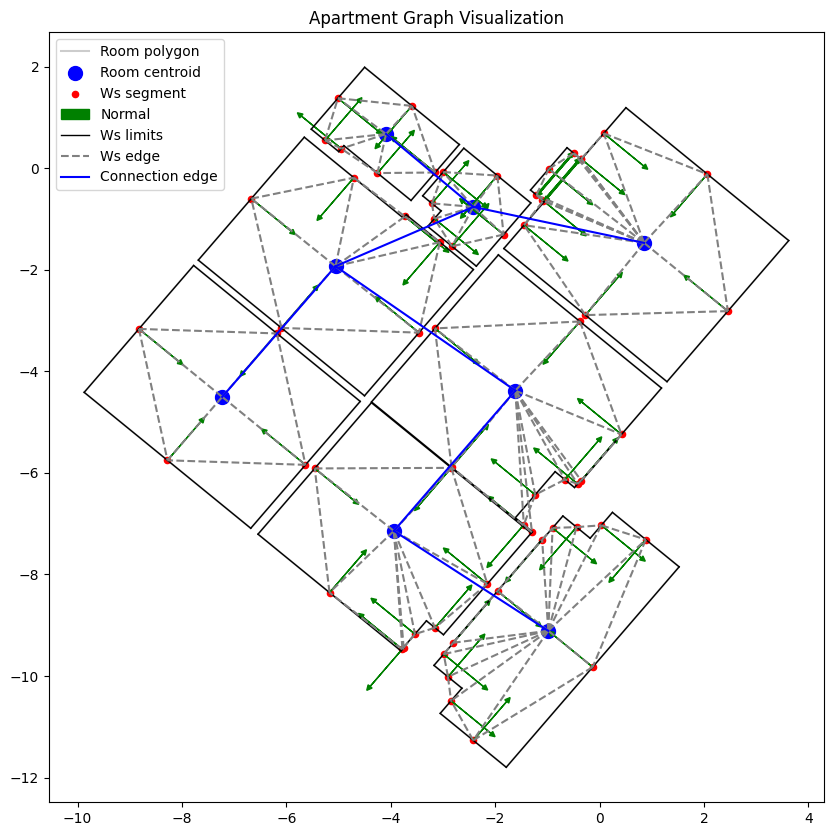

In [8]:
# Check the number of graphs
print(f"Number of original graphs: {len(original_graphs)}")
print(original_graphs[0])
print(original_graphs[0].nodes(data=True))
print(original_graphs[0].edges(data=True))
plot_a_graph([original_graphs[0]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

 Checks on dataset

In [12]:
assert len(original_graphs) == len(dimensions), "Number of original and dimensions must be the same dim"
tot_graphs = 0
for i in range(len(dimensions)):
    tot_graphs += dimensions[i]
assert len(noise_graphs) == tot_graphs, "Number of noise graphs must be equal to the sum of dimensions"

for i, graph in enumerate(original_graphs):
    assert i == int(graph.graph['name']), "Graph name must match the index"

blocks = []
start = 0
for size in dimensions:
    end = start + size
    blocks.append(noise_graphs[start:end])
    start = end

def assert_block_names(blocks):
    for i, block in enumerate(blocks):
        base_names = [g.graph['name'].split("_")[0] for g in block]
        all_same = all(name == base_names[0] for name in base_names)
        assert all_same, f"Blocco {i+1}: nomi base diversi {base_names}"

assert_block_names(blocks)

53
60
114
60
114


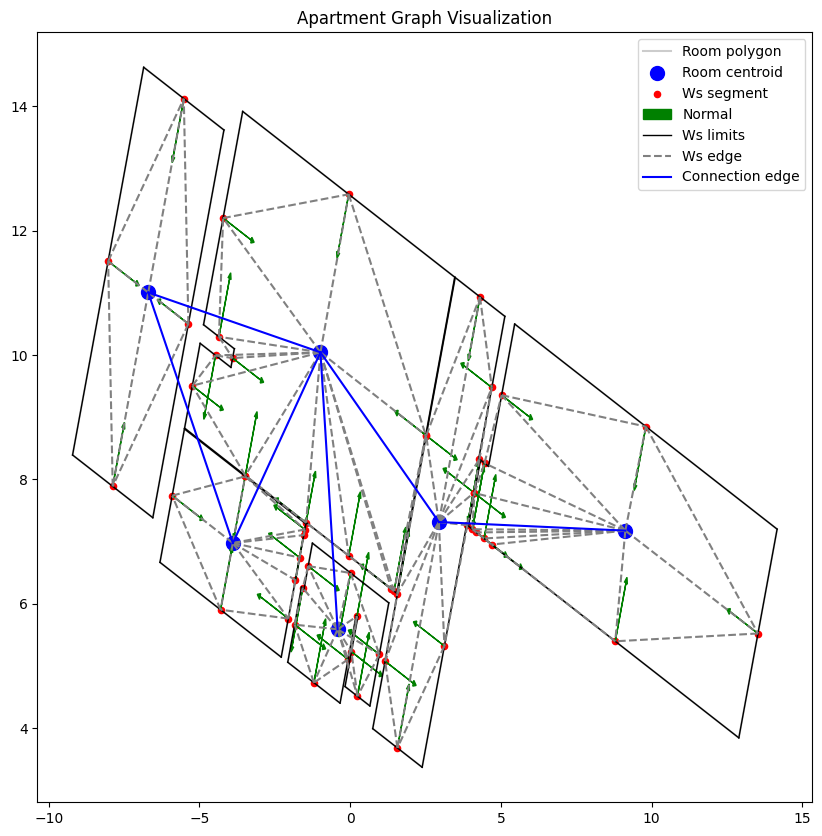

[(0, {'polygon': [(3.909681495529636, 7.255006758279187), (3.8657280439373594, 7.27164868381054), (2.389440621972617, 3.3725849837977826), (0.7496631601137329, 3.9934475877495004), (1.5706837376018754, 6.161867831002091), (1.5611010066652078, 6.165496103387028), (3.4846610890040832, 11.245864045463948), (5.133949317747049, 10.621400416598437), (4.267869549428683, 8.33397309335308), (4.311894965073545, 8.317303920350579), (3.909681495529636, 7.255006758279187)], 'center': [2.9446048656149997, 7.314952721033546], 'normal': [0, 0], 'type': 'room', 'category': 4, 'category_letter': 'Corridor', 'viz_data': [2.9446048656149997, 7.314952721033546]}), (1, {'geom': [array([3.9096815 , 7.25500676]), array([3.86572804, 7.27164868])], 'polygon': [(3.909681495529636, 7.255006758279187), (3.8657280439373594, 7.27164868381054), (3.8657280439373594, 7.281648683810539), (3.909681495529636, 7.265006758279187), (3.909681495529636, 7.255006758279187)], 'center': [3.8877047697334977, 7.263327721044863], 'n

In [9]:
print(original_graphs[53].graph['name'])
print(len(original_graphs[53].nodes))
print(len(original_graphs[53].edges))
# remove all node which has type != "room" or "ws"
def remove_non_room_ws(graphs):
    for graph in graphs:
        nodes_to_remove = [n for n, d in graph.nodes(data=True) if d['type'] not in ['room', 'ws']]
        graph.remove_nodes_from(nodes_to_remove)
    return graphs
original_graphs = remove_non_room_ws(original_graphs)
noise_graphs = remove_non_room_ws(noise_graphs)

# convert id to int
for i, graph in enumerate(original_graphs):
    original_graphs[i] = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='default')
for i, graph in enumerate(noise_graphs):
    noise_graphs[i] = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='default')


print(len(original_graphs[53].nodes))
print(len(original_graphs[53].edges))
plot_a_graph([original_graphs[53]], viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=False)
print(original_graphs[53].nodes(data=True))
print(original_graphs[53].edges(data=True))

#### Generate G1,G2,GT dataset

Data(x=[96, 7], edge_index=[2, 181], node_names=[96], name='736')
G1 nodes: tensor([ 2.9364e+00, -2.9364e+00,  1.0370e-01, -1.8011e-01, -2.2960e-03,
         4.6078e-03, -6.7941e-01])
Data(x=[96, 7], edge_index=[2, 181], node_names=[96], name='736')
G2 permuted nodes: tensor([-0.3406,  0.3406,  0.0715, -0.0165, -0.2724, -1.4652,  1.0842])
Ground truth permutation:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])


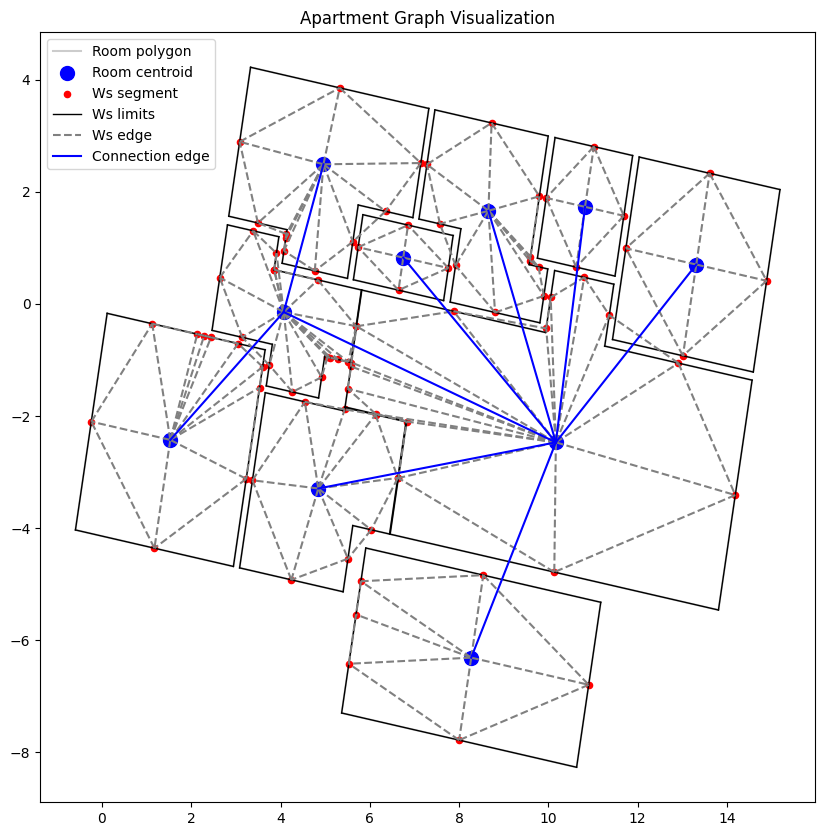

In [10]:
# Split the data into 70% train, 15% validation, and 15% test
def split_graphs(graphs):
    train, temp = train_test_split(graphs, test_size=0.3, random_state=seed)
    val, test = train_test_split(temp, test_size=0.5, random_state=seed)
    return train, val, test

train, val, test = split_graphs(original_graphs)

train_list = []
for i, g1 in enumerate(train):
    generate_matching_pair_as_data(g1, g1, train_list)

val_list = []
for i, g1 in enumerate(val):
    generate_matching_pair_as_data(g1, g1, val_list)

test_list = []
for i, g1 in enumerate(test):
    generate_matching_pair_as_data(g1, g1, test_list)


# compute mean and std
mean, std = compute_mean_std(train_list)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train_list, mean, std)
val_pairs_norm = normalize_data_pairs(val_list, mean, std)
test_pairs_norm = normalize_data_pairs(test_list, mean, std)


# Visualize the two graphs
g1_out, g2_perm, gt_perm = train_list[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

g1_out = pyg_data_to_nx_digraph(g1_out, original_graphs)
g2_perm = pyg_data_to_nx_digraph(g2_perm, original_graphs)

plot_a_graph(
    graphs_list=[g1_out],
    viz_rooms=True,
    viz_ws=True,
    viz_openings=False,
    viz_room_connection=True,
    viz_normals=False,
    viz_room_normals=False,
    viz_walls=False
)

In [11]:
from torch.utils.data import Dataset

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):  # lista di (Data, Data, P)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]  # data1, data2, P
    
from torch_geometric.data import Batch

def collate_pyg_matching(batch):
    data1_list, data2_list, perm_list = zip(*batch)
    batch1 = Batch.from_data_list(data1_list)
    batch2 = Batch.from_data_list(data2_list)
    return batch1, batch2, perm_list

train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

## Equal graphs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import pygmtools

pygmtools.BACKEND = 'pytorch'

class MatchingModel_GATv2Sinkhorn(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.gnn = nn.ModuleList([
            GATv2Conv(in_dim, hidden_dim),
            GATv2Conv(hidden_dim, out_dim)
        ])
        self.inst_norm = nn.InstanceNorm2d(1, affine=True)

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
        return x

    def forward(self, batch1, batch2, batch_idx1, batch_idx2):
        x1, edge1 = batch1.x.to(device), batch1.edge_index.to(device)
        x2, edge2 = batch2.x.to(device), batch2.edge_index.to(device)
        batch_idx1 = batch1.batch.to(device)
        batch_idx2 = batch2.batch.to(device)


        h1 = self.encode(x1, edge1)
        h2 = self.encode(x2, edge2)

        B = batch1.num_graphs
        perm_pred_list = []
        all_embeddings = []

        for i in range(B):
            h1_i = h1[batch_idx1 == i]  # [N1, d]
            h2_i = h2[batch_idx2 == i]  # [N2, d]

            sim = torch.matmul(h1_i, h2_i.T)  # [N1, N2]
            sim_batched = sim.unsqueeze(0).unsqueeze(1)  # [1, 1, N1, N2]
            sim_normed = self.inst_norm(sim_batched).squeeze(1)  # [1, N1, N2]

            n1 = torch.tensor([h1_i.size(0)], dtype=torch.int32)
            n2 = torch.tensor([h2_i.size(0)], dtype=torch.int32)

            S = pygmtools.sinkhorn(sim_normed, n1=n1, n2=n2, dummy_row=False)[0]  # [N1, N2]

            perm_pred_list.append(S)
            all_embeddings.append((h1_i, h2_i))

        return perm_pred_list, all_embeddings


/Users/matteogiorgi/Github/GNN_Notebooks/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/matteogiorgi/Github/GNN_Notebooks/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def train_epoch_sinkhorn(model, loader, optimizer):
    model.train()
    total_loss = 0
    all_embeddings = []

    for batch1, batch2, perm_list in tqdm(loader):
        optimizer.zero_grad()
        batch_idx1 = batch1.batch
        batch_idx2 = batch2.batch

        pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

        loss = sum(F.binary_cross_entropy(pred, target) for pred, target in zip(pred_perm_list, perm_list))
        loss /= len(perm_list)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_embeddings.extend(batch_embeddings)

    avg_loss = total_loss / len(loader)
    return avg_loss, all_embeddings

def evaluate_sinkhorn(model, loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    all_embeddings = []

    with torch.no_grad():
        for batch1, batch2, perm_list in loader:
            batch_idx1 = batch1.batch
            batch_idx2 = batch2.batch

            pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

            for pred, target in zip(pred_perm_list, perm_list):

                pred_indices = pred.argmax(dim=1)
                target_indices = target.argmax(dim=1)
                correct += (pred_indices == target_indices).sum().item()
                total += pred.size(0)

            loss = sum(F.binary_cross_entropy(pred, target) for pred, target in zip(pred_perm_list, perm_list))
            total_loss += loss.item()
            all_embeddings.extend(batch_embeddings)

    avg_acc = correct / total if total > 0 else 0
    avg_loss = total_loss / len(loader)
    return avg_acc, avg_loss, all_embeddings



In [ ]:
from torch.utils.data import DataLoader
import os

# Percorsi per salvare i modelli
best_val_model_path = os.path.join(gm_equal_path, 'best_val_model.pt')
final_model_path = os.path.join(gm_equal_path, 'final_model.pt')

# Iperparametri
in_dim = 7
hidden_dim = 64
out_dim = 32
num_epochs = 100
learning_rate = 0.001
batch_size = 3

# Early stopping
best_val_loss = float('inf')
patience = 10
patience_counter = 0
best_epoch = -1

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2Sinkhorn(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Tracciamento delle loss
train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(num_epochs):
    # Train
    train_loss, train_embeddings = train_epoch_sinkhorn(model, train_loader, optimizer)
    # Validate
    val_acc, val_loss, val_embeddings = evaluate_sinkhorn(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Salva il miglior modello
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        torch.save(model.state_dict(), best_val_model_path)
    else:
        patience_counter += 1

    # Logging
    print(f"Epoch {epoch:03} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Best was {best_epoch}.")
        break

# Salva anche il modello finale
torch.save(model.state_dict(), final_model_path)
print("\nTraining completed.")


Starting training...
Epoch 000 | Train Loss: 0.0510 | Val Loss: 0.1131 | Val Acc: 0.7695
Epoch 001 | Train Loss: 0.0300 | Val Loss: 0.0710 | Val Acc: 0.8988
Epoch 002 | Train Loss: 0.0198 | Val Loss: 0.0499 | Val Acc: 0.9491
Epoch 003 | Train Loss: 0.0138 | Val Loss: 0.0346 | Val Acc: 0.9737


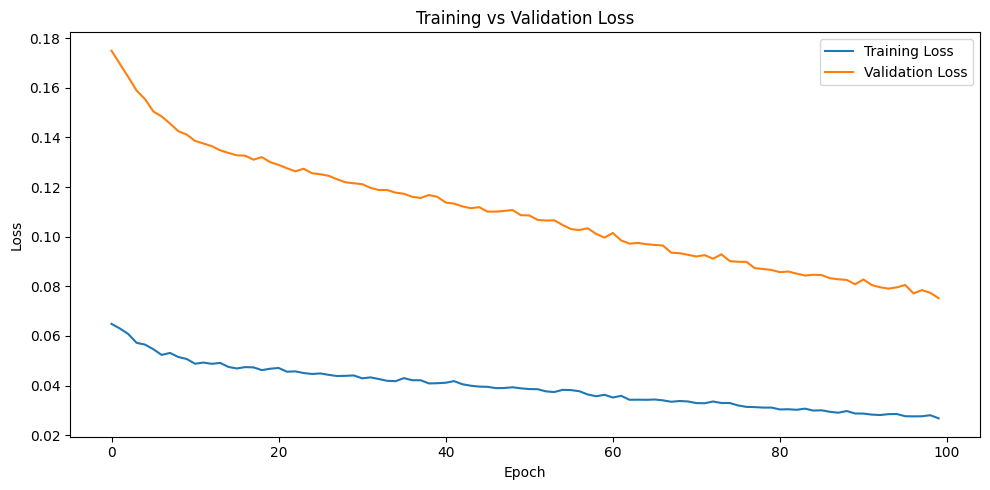

In [23]:
plot_losses(train_losses, val_losses)

In [ ]:
def predict_matching_matrix(model, data1, data2):
    model.eval()
    with torch.no_grad():
        data1 = data1.to(device)
        data2 = data2.to(device)
        h1 = model.encode(data1.x, data1.edge_index).unsqueeze(0)  # [1, N1, D]
        h2 = model.encode(data2.x, data2.edge_index).unsqueeze(0)  # [1, N2, D]

        M = torch.matmul(h1, h2.transpose(1, 2))  # [1, N1, N2]
        M = model.inst_norm(M.unsqueeze(1)).squeeze(1)  # [1, N1, N2]

        n1 = torch.tensor([h1.shape[1]], dtype=torch.int32)  # as Tensor
        n2 = torch.tensor([h2.shape[1]], dtype=torch.int32)

        pred = pygmtools.hungarian(M, n1=n1, n2=n2).squeeze(0)  # [N1, N2]
        return pred

In [ ]:
model.load_state_dict(torch.load(best_val_model_path, map_location=device))
model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# use the model to predict the matching on a test graph
for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):    
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm)
    end_time = time.time()
    inference_time += end_time - start_time
    errors = (result != gt_perm).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

print(f"Inference time: {inference_time/len(test_list):.6f} seconds")

Test Accuracy: 1.0000 | Test Loss: 0.0797


NameError: name 'time' is not defined

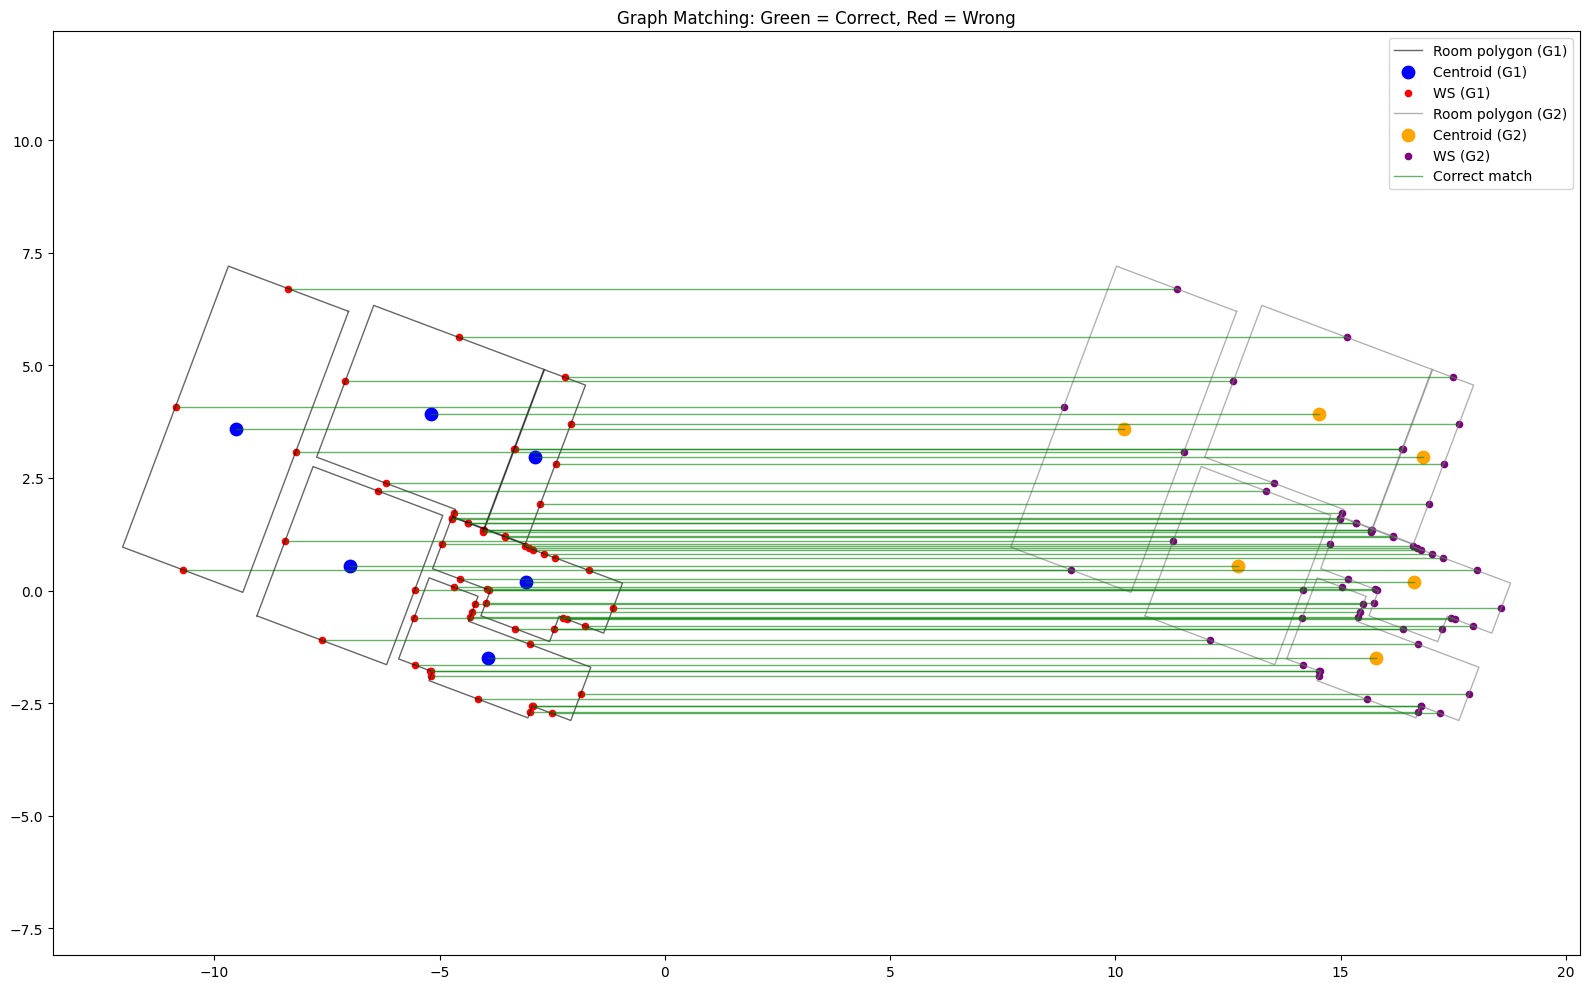

In [ ]:
g1_out, g2_perm, gt_perm = test_list[0]
result = predict_matching_matrix(model, g1_out, g2_perm)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
)

## Local noise 

## Local noise 

## Global + Local noise 

# Partial graph matching

## Ws dropout

## Room Dropout

## Ws + Room Dropout